In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from nltk.metrics.agreement import AnnotationTask
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize import TweetTokenizer
from nltk.util import bigrams
from nltk.lm import Lidstone
from pprint import pprint
from tabulate import tabulate
from functions import preprocess, preprocess_tweet
from itertools import combinations
from tqdm import tqdm
!rm -rf figures
!mkdir figures

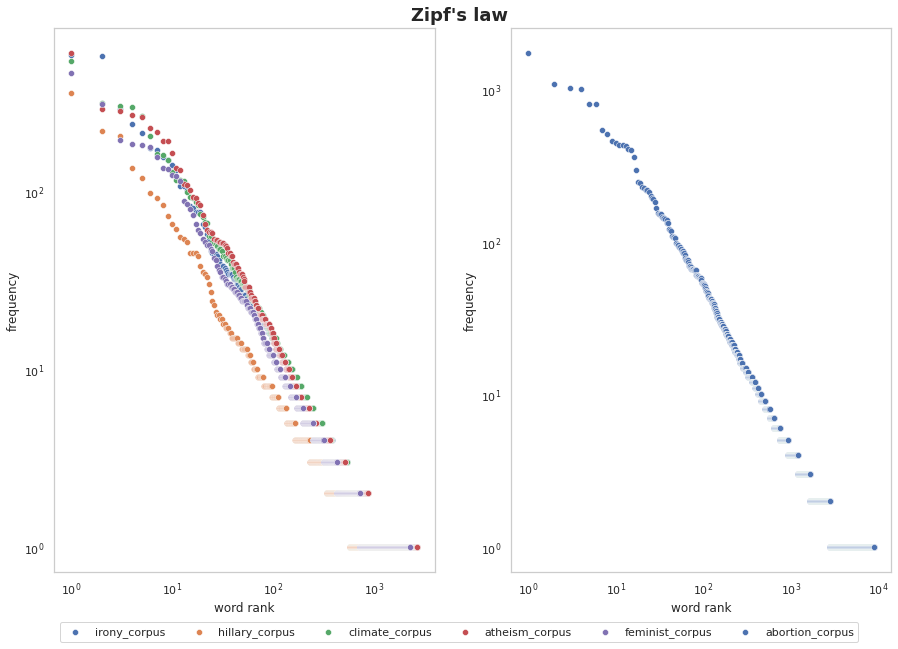

In [2]:
def datfr(corpus):
    voc = Counter(corpus)
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(corpus)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()
    sns.set_theme(style='whitegrid')
    return(frq)

# Irony 
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony = "\n".join(preprocess(f.read().rstrip()))

# Multiclass stance 
with open("tweeteval/datasets/stance/climate/train_text.txt", "r") as f:
    stance_climate = "\n".join(preprocess(f.read().rstrip()))

with open("tweeteval/datasets/stance/hillary/train_text.txt", "r") as f:
    stance_hillary = "\n".join(preprocess(f.read().rstrip()))

with open("tweeteval/datasets/stance/feminist/train_text.txt", "r") as f:
    stance_feminist = "\n".join(preprocess(f.read().rstrip()))

with open("tweeteval/datasets/stance/abortion/train_text.txt", "r") as f:
    stance_abortion = "\n".join(preprocess(f.read().rstrip()))

with open("tweeteval/datasets/stance/atheism/train_text.txt", "r") as f:
    stance_atheism = "\n".join(preprocess(f.read().rstrip()))

with open("pattern.txt", "r") as f:
    pat = re.compile(f.read())

irony_corpus = re.findall(pat, irony)

climate_corpus = re.findall(pat, stance_climate)

hillary_corpus = re.findall(pat, stance_hillary)

feminist_corpus = re.findall(pat, stance_feminist)

abortion_corpus = re.findall(pat, stance_abortion)

atheism_corpus = re.findall(pat, stance_atheism)

tokenised_datasets = [irony_corpus, hillary_corpus, climate_corpus, atheism_corpus, feminist_corpus, abortion_corpus]

names = ["irony_corpus","hillary_corpus", "climate_corpus", "atheism_corpus", "feminist_corpus", "abortion_corpus"]

irony_df = datfr(irony_corpus)
hillary_df = datfr(hillary_corpus)
climate_df = datfr(climate_corpus)
abortion_df = datfr(abortion_corpus)
feminist_df = datfr(feminist_corpus)
atheism_df = datfr(atheism_corpus)

all_dfs = [irony_df, hillary_df, climate_df, abortion_df, feminist_df, atheism_df]
fig,axs = plt.subplots(1,2,figsize=(15,10))

c = 0
for df in all_dfs:
    if c == 0:
        sns.scatterplot(x='idx', y='frequency', data=df, ax = axs[1])
        c += 1
    else:
        sns.scatterplot(x='idx', y='frequency', data=df, ax = axs[0])
for ax in axs:
    ax.set(xscale="log", yscale="log")
    ax.grid(False)
    ax.set_xlabel("word rank")
fig.suptitle("Zipf's law", fontweight="bold", fontsize=18, x=0.5,y=0.91)
fig.legend(labels=names, loc = "lower center", bbox_to_anchor=(0.5,0.02), ncol=6)
plt.savefig("figures/zipf_law.png", dpi=400, bbox_inches="tight")

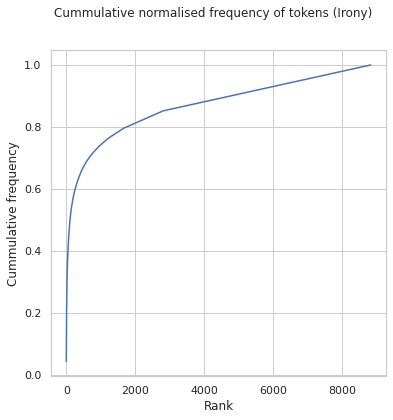

In [3]:
y = (irony_df["cumul_frq"])
x = (irony_df["idx"])
plt.figure(figsize=(6, 6))
plt.plot(x,y)
plt.axes
plt.xlabel('Rank')
plt.ylabel('Cummulative frequency')
plt.suptitle('Cummulative normalised frequency of tokens (Irony)')
plt.savefig('figures/cumul_dist_irony.png')

In [4]:
random.seed(10)

lines = []
with open("tweeteval/datasets/irony/train_text.txt") as f:
    for line in f:
        lines.append(line.strip())

random_lines_index = sorted(random.sample([i for i in range(0, len(lines))], k = 100))

true_vals = []
with open("tweeteval/datasets/irony/train_labels.txt") as f:
    for line in f:
        true_vals.append(int(line.strip()))

validation = []
for i in random_lines_index:
    validation.append(true_vals[i])

with open("manual_annotation.txt", "w") as f:
    for i in range(100):
        f.write(f"{random_lines_index[i]}@@@ {lines[random_lines_index[i]]}")
        f.write("\n")

df = pd.read_csv("manual_annotations/annotation_results.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
df["Gold"] = validation
names = ["Marie", "Frida", "Magnus", "Viggo", "Gustav"]

tuple_list = []
for name in list(df)[1:]:
    tuples = list(zip([name] * len(df["idx"]), df["idx"], df[name]))
    tuple_list.extend(tuples)

manual_gold = AnnotationTask(data=tuple_list)

combs = list(map(lambda x: (x[0], x[1], manual_gold.kappa_pairwise(*x)), combinations(names, 2)))
combs.extend(map(lambda x: (x[0], x[1], manual_gold.kappa_pairwise(*x)), zip(names, ["Gold"] * len(names))))
table = tabulate(combs, headers=["Annotator 1", "Annotator 2", "Kappa Pairwise"], tablefmt="latex_booktabs", floatfmt=".3f")
print(table)
print(f"\n###  Average Agreement with Gold: {np.mean(list(map(lambda x: x[2], combs[-5:]))):.3f}")

\begin{tabular}{llr}
\toprule
 Annotator 1   & Annotator 2   &   Kappa Pairwise \\
\midrule
 Marie         & Frida         &            0.376 \\
 Marie         & Magnus        &            0.408 \\
 Marie         & Viggo         &            0.362 \\
 Marie         & Gustav        &            0.333 \\
 Frida         & Magnus        &            0.601 \\
 Frida         & Viggo         &            0.606 \\
 Frida         & Gustav        &            0.470 \\
 Magnus        & Viggo         &            0.615 \\
 Magnus        & Gustav        &            0.440 \\
 Viggo         & Gustav        &            0.486 \\
 Marie         & Gold          &            0.517 \\
 Frida         & Gold          &            0.364 \\
 Magnus        & Gold          &            0.545 \\
 Viggo         & Gold          &            0.465 \\
 Gustav        & Gold          &            0.403 \\
\bottomrule
\end{tabular}

###  Average Agreement with Gold: 0.459


In [5]:
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony = preprocess(f.read().rstrip())
with open("pattern.txt", "r") as f:
    pat = re.compile(f.read())

def statistics(corpus):
    counts = Counter(corpus)
    corpus_size = len(corpus)
    vocab_size = len(counts)
    return (counts, corpus_size, vocab_size, vocab_size/corpus_size)

datasets = ["abortion", "atheism", "climate", "feminist", "hillary", "irony"]
stance_texts = []
for stance in datasets[:-1]:
    with open(f"tweeteval/datasets/stance/{stance}/test_text.txt") as f:
        stance_texts.append(preprocess(f.read().rstrip()))

stance_texts.append(irony)

for text, stance in zip(stance_texts, datasets):
    print(stance.title())
    corpus = re.findall(pat, "\n".join(text))
    stats = statistics(corpus)
    print(f"Corpus size: {stats[1]}\t Vocabulary size: {stats[2]}\tType/token ratio: {stats[3]:.3}")
    #print(datfr(corpus).head(10))
    print()

Abortion
Corpus size: 4887	 Vocabulary size: 1536	Type/token ratio: 0.314

Atheism
Corpus size: 3909	 Vocabulary size: 1425	Type/token ratio: 0.365

Climate
Corpus size: 2852	 Vocabulary size: 1198	Type/token ratio: 0.42

Feminist
Corpus size: 5148	 Vocabulary size: 1618	Type/token ratio: 0.314

Hillary
Corpus size: 5076	 Vocabulary size: 1560	Type/token ratio: 0.307

Irony
Corpus size: 40592	 Vocabulary size: 8821	Type/token ratio: 0.217



In [6]:
with open("tweeteval/datasets/irony/train_text.txt", "r", encoding="utf8") as f:
    irony_train_data = preprocess(f.read().rstrip())
pattern = re.compile(TweetTokenizer().WORD_RE.pattern, flags=re.I|re.VERBOSE|re.UNICODE)
with open("tweeteval/datasets/offensive/train_text.txt", "r", encoding="utf8") as f:
    offensive_train = preprocess(f.read().rstrip())
with open("tweeteval/datasets/offensive/val_text.txt", "r", encoding="utf8") as f:
    offensive_val = preprocess(f.read().rstrip())
offensive = np.concatenate((offensive_train, offensive_val))

irony_tokens = [re.findall(pattern, tweet) for tweet in irony_train_data]
offensive_tokens = [re.findall(pattern, tweet) for tweet in offensive]
_, vocab = padded_everygram_pipeline(2, irony_tokens + offensive_tokens)
train, _ = padded_everygram_pipeline(2, irony_tokens)
lm = Lidstone(0.2, 2)
lm.fit(train, vocab)
perplexities = []
ngrams_linewise = list(bigrams(tweet) for tweet in offensive)
print("Calculating perplexities...")
for tweet in tqdm(ngrams_linewise):
    try:
        perplexity = lm.perplexity(tweet)
        perplexities.append(perplexity)
    except ZeroDivisionError:
        perplexity = math.inf
        perplexities.append(perplexity)
df = pd.DataFrame(data = {"index": [i for i in range(len(perplexities))], "perp": perplexities})
df = df.sort_values(by="perp")
index = df["index"].tolist()
aug_tweets_irony = [preprocess_tweet(offensive[i]) for i in index]
irony_train_labels = np.loadtxt("tweeteval/datasets/irony/train_labels.txt")
with open("tweeteval/datasets/irony/val_text.txt", "r", encoding="utf8") as f:
    irony_val_data = preprocess(f.read().rstrip())
irony_val_labels = np.loadtxt("tweeteval/datasets/irony/val_labels.txt")

classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
clf.fit(irony_train_data, irony_train_labels)
aug_pred_val_irony = clf.predict(aug_tweets_irony)

Calculating perplexities...
100%|██████████| 13240/13240 [00:12<00:00, 1102.25it/s]


Testing models...
100%|██████████| 26/26 [01:58<00:00,  4.57s/it]


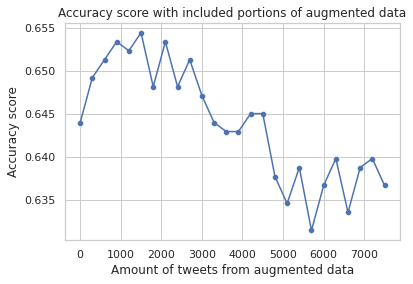

In [7]:
n_irony = len(irony_train_labels)
mixed_train_data = np.concatenate([irony_train_data, aug_tweets_irony])
mixed_train_labels = np.concatenate([irony_train_labels, aug_pred_val_irony])

portions = list(range(0, 7501, 300))
acc_scores = np.empty((len(portions)))

print("Testing models...")
for i, portion in tqdm(list(enumerate(portions))):
    x_train = mixed_train_data[:n_irony + portion]
    y_train = mixed_train_labels[:n_irony + portion]

    classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
    clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
    clf.fit(x_train, y_train);

    y_pred_val = clf.predict(irony_val_data)
    acc_scores[i] = accuracy_score(irony_val_labels, y_pred_val)
sns.set_theme("notebook")
sns.set_style("whitegrid")
fig = sns.scatterplot(x=portions, y=acc_scores)
sns.lineplot(x = portions, y = acc_scores)
fig.set_title("Accuracy score with included portions of augmented data")
fig.set_xlabel("Amount of tweets from augmented data")
fig.set_ylabel("Accuracy score")
plt.savefig("figures/aug_data_irony_line.png", dpi=400, bbox_inches="tight")

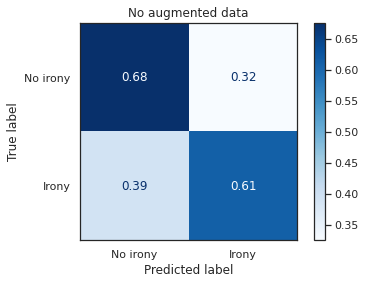

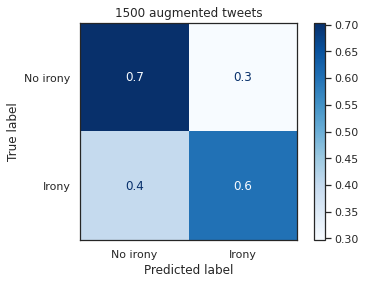

In [8]:
sns.set_style("white")
n_irony = len(irony_train_labels)
mixed_train_data = np.concatenate([irony_train_data, aug_tweets_irony])
mixed_train_labels = np.concatenate([irony_train_labels, aug_pred_val_irony])
conf_mat_labels = ["No irony", "Irony"]
classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf_irony = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                    TfidfTransformer(), classifier)
clf_irony.fit(irony_train_data, irony_train_labels)
y_pred_val = clf_irony.predict(irony_val_data)
conf_mat = confusion_matrix(irony_val_labels, y_pred_val)
display = ConfusionMatrixDisplay(normalize(conf_mat, "l1"), display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("No augmented data")

classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf_irony_aug = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                    TfidfTransformer(), classifier)
clf_irony_aug.fit(mixed_train_data[:n_irony + 1500], mixed_train_labels[:n_irony + 1500])
y_pred_val = clf_irony_aug.predict(irony_val_data)
conf_mat = confusion_matrix(irony_val_labels, y_pred_val)
display = ConfusionMatrixDisplay(normalize(conf_mat, "l1"), display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("1500 augmented tweets");

In [9]:
with open("tweeteval/datasets/stance/feminist/train_text.txt", "r", encoding="utf8") as f:
    feminist_train_data = preprocess(f.read().rstrip())
pattern = re.compile(TweetTokenizer().WORD_RE.pattern, flags=re.I|re.VERBOSE|re.UNICODE)
with open("tweeteval/datasets/offensive/train_text.txt", "r", encoding="utf8") as f:
    offensive_train = preprocess(f.read().rstrip())
with open("tweeteval/datasets/offensive/val_text.txt", "r", encoding="utf8") as f:
    offensive_val = preprocess(f.read().rstrip())
offensive = np.concatenate((offensive_train, offensive_val))

feminist_tokens = [re.findall(pattern, tweet) for tweet in feminist_train_data]
offensive_tokens = [re.findall(pattern, tweet) for tweet in offensive]
_, vocab = padded_everygram_pipeline(2, feminist_tokens + offensive_tokens)
train, _ = padded_everygram_pipeline(2, feminist_tokens)
lm = Lidstone(0.2, 2)
lm.fit(train, vocab)
perplexities = []
ngrams_linewise = list(bigrams(tweet) for tweet in offensive)
print("Calculating perplexities...")
for tweet in tqdm(ngrams_linewise):
    try:
        perplexity = lm.perplexity(tweet)
        perplexities.append(perplexity)
    except ZeroDivisionError:
        perplexity = math.inf
        perplexities.append(perplexity)
df = pd.DataFrame(data = {"index": [i for i in range(len(perplexities))], "perp": perplexities})
df = df.sort_values(by="perp")
index = df["index"].tolist()
aug_tweets_feminist = [preprocess_tweet(offensive[i]) for i in index]

feminist_train_labels = np.loadtxt("tweeteval/datasets/stance/feminist/train_labels.txt")
with open("tweeteval/datasets/stance/feminist/val_text.txt", "r", encoding="utf8") as f:
    feminist_val_data = preprocess(f.read().rstrip())
feminist_val_labels = np.loadtxt("tweeteval/datasets/stance/feminist/val_labels.txt")

classifier = MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh', max_iter=500)
clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
clf.fit(feminist_train_data, feminist_train_labels)
aug_pred_val_feminist = clf.predict(aug_tweets_feminist)

Calculating perplexities...
100%|██████████| 13240/13240 [00:11<00:00, 1108.17it/s]


In [10]:
## Creates a plot for the slides, but takes 1hr to run

# n_feminist = len(feminist_train_labels)
# mixed_train_data = np.concatenate([feminist_train_data, aug_tweets_feminist])
# mixed_train_labels = np.concatenate([feminist_train_labels, aug_pred_val_feminist])

# portions = list(range(0, 7501, 300))
# acc_scores = np.empty((len(portions)))

# print("Testing models...")
# for i, portion in tqdm(list(enumerate(portions))):
#     x_train = mixed_train_data[:n_feminist + portion]
#     y_train = mixed_train_labels[:n_feminist + portion]

#     classifier = MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh', max_iter=500)
#     clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
#                         TfidfTransformer(), classifier)
#     clf.fit(x_train, y_train);

#     y_pred_val = clf.predict(feminist_val_data)
#     acc_scores[i] = accuracy_score(feminist_val_labels, y_pred_val)
# sns.set_theme("notebook")
# sns.set_style("whitegrid")
# fig = sns.scatterplot(x=portions, y=acc_scores)
# fig.set_title("Accuracy score with included portions of augmented data")
# fig.set_xlabel("Amount of tweets from augmented data")
# fig.set_ylabel("Accuracy score")
# plt.savefig("figures/aug_data_feminist_7500.png", dpi=400, bbox_inches="tight")

Testing models...
100%|██████████| 20/20 [07:54<00:00, 23.73s/it]


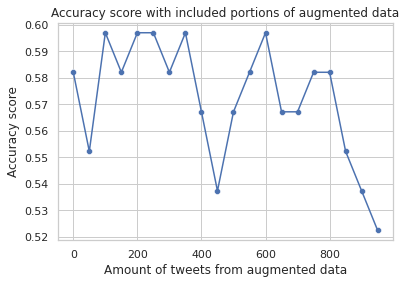

In [15]:
n_feminist = len(feminist_train_labels)
mixed_train_data = np.concatenate([feminist_train_data, aug_tweets_feminist])
mixed_train_labels = np.concatenate([feminist_train_labels, aug_pred_val_feminist])

portions = list(range(0, 1000, 50))
acc_scores = np.empty((len(portions)))

print("Testing models...")
for i, portion in tqdm(list(enumerate(portions))):
    x_train = mixed_train_data[:n_feminist + portion]
    y_train = mixed_train_labels[:n_feminist + portion]

    classifier = MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh', max_iter=500)
    clf = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                        TfidfTransformer(), classifier)
    clf.fit(x_train, y_train);

    y_pred_val = clf.predict(feminist_val_data)
    acc_scores[i] = accuracy_score(feminist_val_labels, y_pred_val)
sns.set_theme("notebook")
sns.set_style("whitegrid")
fig = sns.scatterplot(x=portions, y=acc_scores)
sns.lineplot(x = portions, y = acc_scores)
fig.set_title("Accuracy score with included portions of augmented data")
fig.set_xlabel("Amount of tweets from augmented data")
fig.set_ylabel("Accuracy score")
plt.savefig("figures/aug_data_feminist_line.png", dpi=400, bbox_inches="tight")

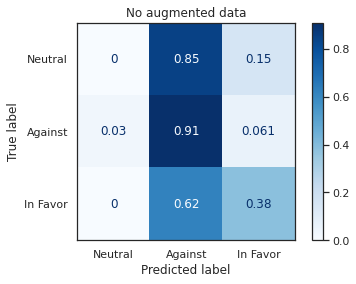

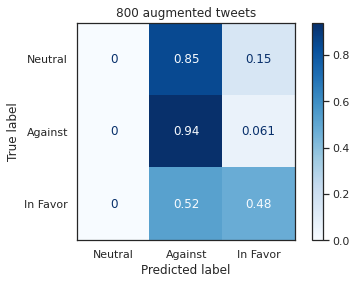

In [12]:
sns.set_style("white")
n_feminist = len(feminist_train_labels)
mixed_train_data = np.concatenate([feminist_train_data, aug_tweets_feminist])
mixed_train_labels = np.concatenate([feminist_train_labels, aug_pred_val_feminist])
conf_mat_labels = ["Neutral", "Against", "In Favor"]
classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf_stance = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                    TfidfTransformer(), classifier)
clf_stance.fit(feminist_train_data, feminist_train_labels)
y_pred_val = clf_stance.predict(feminist_val_data)
conf_mat = confusion_matrix(feminist_val_labels, y_pred_val)
display = ConfusionMatrixDisplay(normalize(conf_mat, "l1"), display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("No augmented data")

classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000)
clf_stance_aug = make_pipeline(CountVectorizer(token_pattern=pattern, strip_accents="unicode"),
                    TfidfTransformer(), classifier)
clf_stance_aug.fit(mixed_train_data[:n_feminist + 800], mixed_train_labels[:n_feminist + 800])
y_pred_val = clf_stance_aug.predict(feminist_val_data)
conf_mat = confusion_matrix(feminist_val_labels, y_pred_val)
display = ConfusionMatrixDisplay(normalize(conf_mat, "l1"), display_labels=conf_mat_labels)
fig = display.plot(cmap=plt.cm.Blues)
fig.ax_.set_title("800 augmented tweets");

In [13]:
with open("tweeteval/datasets/irony/test_text.txt", "r") as f:
    irony_test_data = preprocess(f.read().rstrip())
irony_test_labels = np.loadtxt("tweeteval/datasets/irony/test_labels.txt")
stances = ["abortion", "atheism", "climate", "feminist", "hillary"]
stance_data = []
stance_labels = []
for i, stance in enumerate(stances):
    with open(f"tweeteval/datasets/stance/{stance}/test_text.txt", "r") as f:
        stance_data.append(preprocess(f.read().rstrip()))
    stance_labels.append(np.loadtxt(f"tweeteval/datasets/stance/{stance}/test_labels.txt"))

acc_scores = np.empty((12))
precision_scores = np.empty((12))
recall_scores = np.empty((12))
f1_scores = np.empty((12))

i = 0
y_pred_val = clf_irony.predict(irony_test_data)
acc_scores[i] = accuracy_score(irony_test_labels, y_pred_val)
precision_scores[i] = metrics.precision_score(irony_test_labels, y_pred_val)
recall_scores[i] = metrics.recall_score(irony_test_labels, y_pred_val)
f1_scores[i] = metrics.f1_score(irony_test_labels, y_pred_val)
i += 1

y_pred_val = clf_irony_aug.predict(irony_test_data)
acc_scores[i] = accuracy_score(irony_test_labels, y_pred_val)
precision_scores[i] = metrics.precision_score(irony_test_labels, y_pred_val)
recall_scores[i] = metrics.recall_score(irony_test_labels, y_pred_val)
f1_scores[i] = metrics.f1_score(irony_test_labels, y_pred_val)
i += 1

for j, stance in enumerate(stances):
    y_pred_val = clf_stance.predict(stance_data[j])
    acc_scores[i] = accuracy_score(stance_labels[j], y_pred_val)
    precision_scores[i] = metrics.precision_score(stance_labels[j], y_pred_val, average="macro")
    recall_scores[i] = metrics.recall_score(stance_labels[j], y_pred_val, average="macro")
    f1_scores[i] = metrics.f1_score(stance_labels[j], y_pred_val, average="macro")
    i += 1

    y_pred_val = clf_stance_aug.predict(stance_data[j])
    acc_scores[i] = accuracy_score(stance_labels[j], y_pred_val)
    precision_scores[i] = metrics.precision_score(stance_labels[j], y_pred_val, average="macro")
    recall_scores[i] = metrics.recall_score(stance_labels[j], y_pred_val, average="macro")
    f1_scores[i] = metrics.f1_score(stance_labels[j], y_pred_val, average="macro")
    i += 1
    header = []
acc_scores = np.r_[["acc\\_score"], acc_scores]
precision_scores = np.r_[["precision"], precision_scores]
recall_scores = np.r_[["recall"], recall_scores]
f1_scores = np.r_[[r"\global\rownum=1\relax f1-score"], f1_scores]
for dataset in ["irony"] + stances:
    header.append(r"\begin{rotate}{45} " + dataset + r" \end{rotate}")
rows = [
    [r"\textbf{No data augmentation}"] + [None] * 6,
    acc_scores[::2],
    precision_scores[::2],
    recall_scores[::2],
    f1_scores[::2],
    [r"\textbf{Data augmentation}"] + [None] * 6,
    np.r_[["acc\\_score"], acc_scores[1::2]],
    np.r_[["precision"], precision_scores[1::2]],
    np.r_[["recall"], recall_scores[1::2]],
    np.r_[["f1-score"], f1_scores[1::2]],
]
print(tabulate(rows, headers=header, numalign="center", floatfmt=".3f", tablefmt="latex_raw"))

\begin{tabular}{lcccccc}
\hline
                                 &  \begin{rotate}{45} irony \end{rotate}  &  \begin{rotate}{45} abortion \end{rotate}  &  \begin{rotate}{45} atheism \end{rotate}  &  \begin{rotate}{45} climate \end{rotate}  &  \begin{rotate}{45} feminist \end{rotate}  &  \begin{rotate}{45} hillary \end{rotate}  \\
\hline
 \textbf{No data augmentation}   &                                         &                                            &                                           &                                           &                                            &                                           \\
 acc\_score                      &                  0.642                  &                   0.582                    &                   0.582                   &                   0.278                   &                   0.568                    &                   0.495                   \\
 precision                       &                  0.542    

In [14]:
!mkdir -p tokenized_datasets/irony
!mkdir -p tokenized_datasets/stance/climate
!mkdir -p tokenized_datasets/stance/hillary
!mkdir -p tokenized_datasets/stance/feminist
!mkdir -p tokenized_datasets/stance/abortion
!mkdir -p tokenized_datasets/stance/atheism

# Irony
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony_train = "\n".join(preprocess(f.read().rstrip()))
with open("tweeteval/datasets/irony/val_text.txt", "r") as f:
    irony_val = "\n".join(preprocess(f.read().rstrip()))
with open("tweeteval/datasets/irony/test_text.txt", "r") as f:
    irony_test = "\n".join(preprocess(f.read().rstrip()))

stances = ["climate", "hillary", "feminist", "abortion", "atheism"]
stance_texts_train = []
stance_texts_val = []
stance_texts_test = []

for stance in stances:
    with open(f"tweeteval/datasets/stance/{stance}/train_text.txt", "r") as f:
        stance_texts_train.append("\n".join(preprocess(f.read().rstrip())))
    with open(f"tweeteval/datasets/stance/{stance}/val_text.txt", "r") as f:
        stance_texts_val.append("\n".join(preprocess(f.read().rstrip())))
    with open(f"tweeteval/datasets/stance/{stance}/test_text.txt", "r") as f:
        stance_texts_test.append("\n".join(preprocess(f.read().rstrip())))

with open("pattern.txt", "r") as f:
    pat = re.compile(f.read())

with open("tokenized_datasets/irony/train_text_tokenized.txt", "w") as f:
    f.write(" ".join(re.findall(pat, irony_train)))
with open("tokenized_datasets/irony/train_val_tokenized.txt", "w") as f:
    f.write(" ".join(re.findall(pat, irony_val)))
with open("tokenized_datasets/irony/train_test_tokenized.txt", "w") as f:
    f.write(" ".join(re.findall(pat, irony_test)))

for i, stance in enumerate(stances):
    with open(f"tokenized_datasets/stance/{stance}/train_text_tokenized.txt", "w") as f:
        f.write(" ".join(re.findall(pat, stance_texts_train[i])))
    with open(f"tokenized_datasets/stance/{stance}/train_val_tokenized.txt", "w") as f:
        f.write(" ".join(re.findall(pat, stance_texts_val[i])))
    with open(f"tokenized_datasets/stance/{stance}/train_test_tokenized.txt", "w") as f:
        f.write(" ".join(re.findall(pat, stance_texts_test[i])))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4cdc3a5-dd4a-4d72-a71a-972cea883107' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>